### Variational Autoencoders 

### Imports and visualization function

In [2]:
import os
from typing import Tuple
import numpy as np
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.nn import functional as F

from torchvision import datasets 
from torchvision.utils import make_grid

### Plotting 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [10]:
def show(img: torch.Tensor, ax=None):
    npimg = img.cpu().numpy()
    if ax is None:
        ax = plt
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

#### Check if torch is avaiable

In [11]:
if torch.cuda.is_available():
    print("Using GPU")

Using GPU


In [ ]:
cifar = datasets.Food101(root='./data/food101', download=True, split='test')

print(cifar[0][0])

plt.imshow(cifar[0][0], interpolation='nearest')
plt.title('Label: {}'.format(cifar[0][1]))
plt.show()

In [ ]:
# train_dataset = getattr(datasets, 'CI')

### Dataloaders

### VAE Model

In Fashion MNIST, the images are of size `28x28`. To aid in visualization, we use a latent space of size 2.
For this practical work the _encoder_ and _decoder_ networks will be simple linear models, with ReLU or Sigmoid activations.

**TODO 1**: Write the encoder $q_{\phi}(z | x)$, for which we define the mean ($\mu$ = `loc`) and log variance($log(\sigma^2) = $`logvar`) of the modeled Gaussian distribution.

**TODO 2**: Write the _reparametrization trick_ : $z = \mu_\phi + \epsilon * \sigma_\phi$, where $\epsilon$ ~ $N(0, 1)$


#### Conclusions

In [8]:
t = torch.Tensor([1, 2, 3, 4, 5])
t.exp()

tensor([  2.7183,   7.3891,  20.0855,  54.5981, 148.4132])

In [10]:
class VAE(nn.Module):
    def __init__(self, z_size: int = 2):
        super(VAE, self).__init__()
        self.__z_size = z_size
        
        # Encoder
        self.enc1 = nn.Linear(784, 512)
        self.enc2 = nn.Linear(512, 256)
        self.enc_loc = nn.Linear(256, z_size) # mu or mean 
        self.enc_logvar = nn.Linear(256, z_size) # log variance
        
        # Decoder
        self.dec1 = nn.Linear(z_size, 256)
        self.dec2 = nn.Linear(256, 512)
        self.dec3 = nn.Linear(512, 784)

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:      
        # Generate a latent vector
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))

        # Estimate the mean and log variance
        loc = self.enc_loc(x)
        logvar = self.enc_logvar(x)

        return loc, logvar
        

    def reparameterize(self, loc: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        z = miu + eps * sigma
        
        Beacuse eps is from N(0, 1) => we use torch.randn_like => and draw a sample of specific shape
        from N(0, 1). Then we multiply it by sigma.
        
        logvar = sqrt(sigma^2) = sigma
        """
        return torch.randn_like(logvar).mul_(0.5 * logvar.exp()).add_(loc)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h = torch.relu(self.dec1(z))
        h = torch.relu(self.dec2(h))
        return torch.sigmoid(self.dec3(h))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        loc, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(loc, logvar)
        return self.decode(z), loc, logvar
      
    def generate(self, nsamples: int, device: torch.device, z: torch.Tensor = None) -> torch.Tensor:
        """A function to generate samples from the model.
        """
        with torch.no_grad():
            if z is None:
                z = torch.randn(nsamples, self.__z_size, device=device)
            return self.decode(z)

## Training the VAE

**TODO 3**: write the ELBO that we are trying to minimize for this case. Since $p(z) ~ N(0, I_2)$ (i.e. we assume a Gaussian prior for the latent space) the two terms (_reconstruction_ and _divergence_ _from_ _prior_ ) of the ELBO take the following forms:
  * $D_{KL}(q_\phi(z|x) || p(z)) = \frac{1}{2} * \sum_{i=1}^k (\sigma_i^2 + \mu_i^2 - log(\sigma_i^2) - 1)$, where `logvar`=$\sigma^2$, and $k$ is the dimensionality of the latent space 
  * rec = $E_{q_\phi(z|x)}[log p_\theta(x|z)] \approx log p_\theta(x|z)$ (i.e. since we do stochastic optimization, the expected reconstruction error is estimated through just a single sample - the current one). This means that the reconstruction error becomes the **binary cross entropy** between the output of the decoder and the true data batch (`data` in the implementation below) which was currently used to condition the generation of `z` samples.

In [20]:
#@title Experiment parameters

z_size = 2 #@param {type:"integer"}
batch_size = 64 #@param {type:"integer"}
lr = 1e-3 #@param {type:"number"}
nepochs = 15 #@param {type:"integer"}
dataset = "FashionMNIST" #@param ["MNIST", "FashionMNIST"]
kl_coeff = 1.0 #@param {type:"number"}

Epoch   1 | KL: 196.286 | BCE: 17539.682
torch.Size([64, 784])


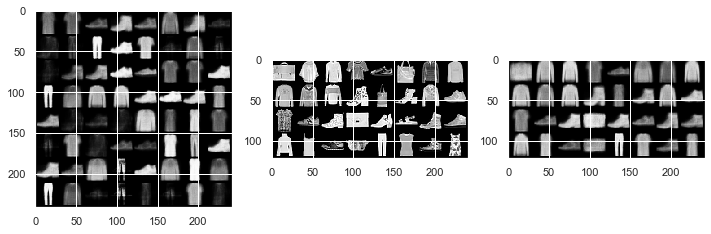

Epoch   2 done.
Epoch   2 | KL: 189.508 | BCE: 16475.183
torch.Size([64, 784])


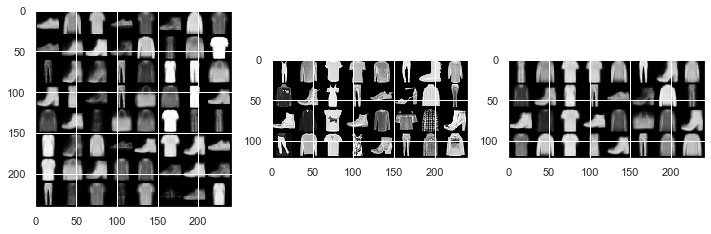

Epoch   3 done.
Epoch   3 | KL: 187.082 | BCE: 16290.700
torch.Size([64, 784])


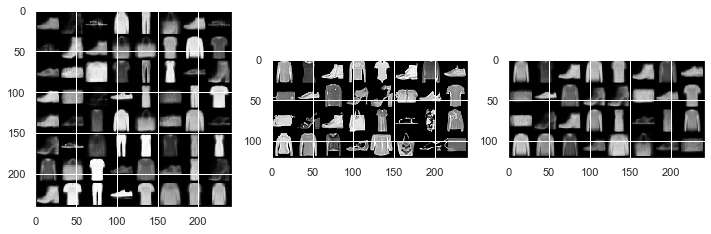

Epoch   4 done.
Epoch   4 | KL: 185.644 | BCE: 16185.256
torch.Size([64, 784])


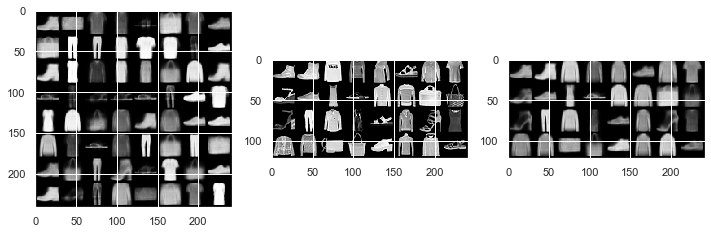

Epoch   5 done.
Epoch   5 | KL: 184.405 | BCE: 16112.462
torch.Size([64, 784])


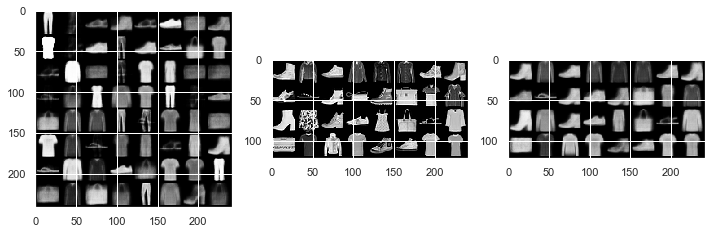

Epoch   6 done.
Epoch   6 | KL: 184.699 | BCE: 16063.361
torch.Size([64, 784])


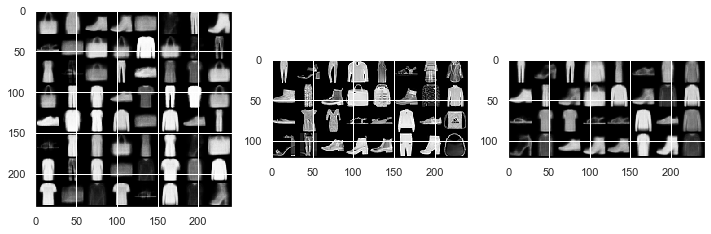

Epoch   7 done.
Epoch   7 | KL: 185.147 | BCE: 16011.983
torch.Size([64, 784])


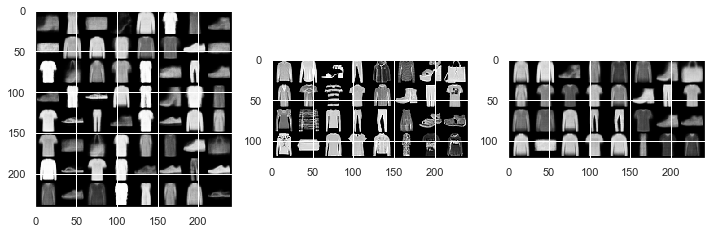

Epoch   8 done.
Epoch   8 | KL: 183.728 | BCE: 15980.855
torch.Size([64, 784])


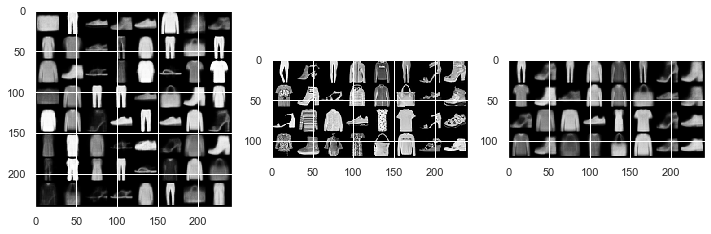

Epoch   9 done.
Epoch   9 | KL: 184.919 | BCE: 15963.728
torch.Size([64, 784])


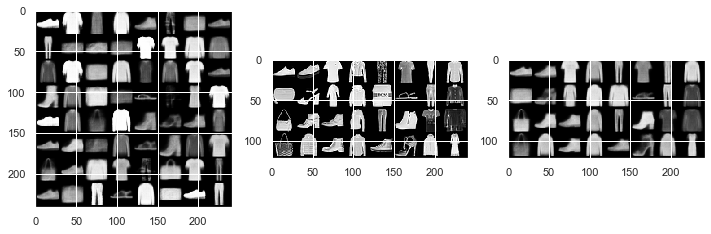

Epoch  10 done.
Epoch  10 | KL: 184.556 | BCE: 15959.336
torch.Size([64, 784])


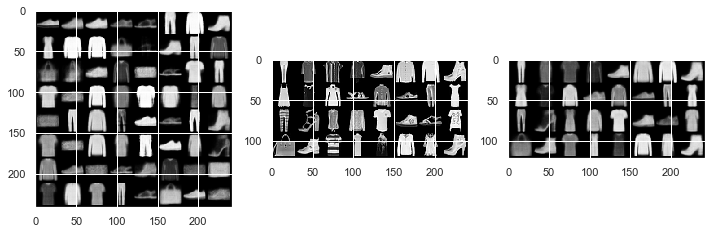

Epoch  11 done.
Epoch  11 | KL: 185.869 | BCE: 15894.303
torch.Size([64, 784])


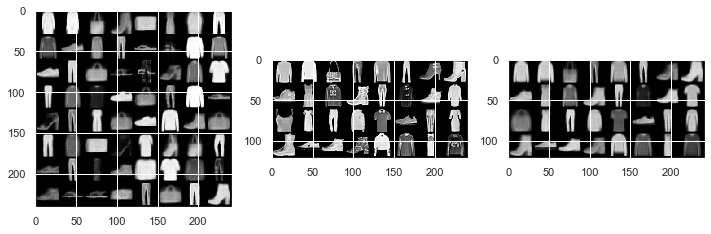

Epoch  12 done.
Epoch  12 | KL: 186.611 | BCE: 15867.062
torch.Size([64, 784])


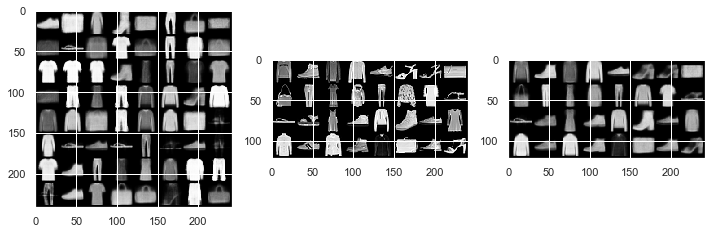

Epoch  13 done.
Epoch  13 | KL: 187.594 | BCE: 15860.119
torch.Size([64, 784])


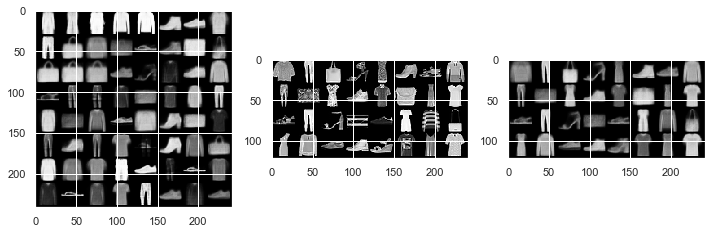

Epoch  14 done.
Epoch  14 | KL: 187.257 | BCE: 15866.695
torch.Size([64, 784])


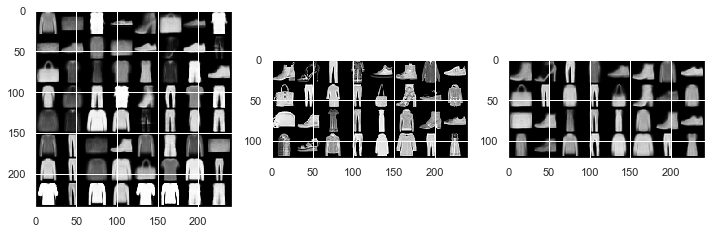

Epoch  15 done.
Epoch  15 | KL: 189.661 | BCE: 15829.723
torch.Size([64, 784])


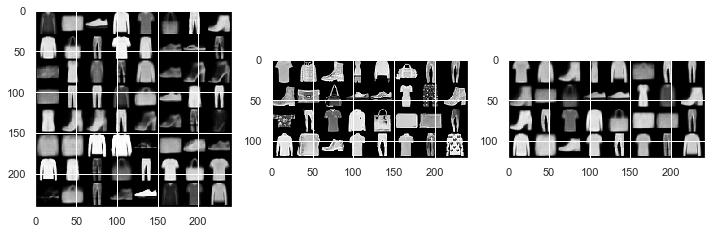

Epoch  16 done.


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = get_loaders(dataset, batch_size, device)
model = VAE(z_size=z_size)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

kls, bces = [], []
step = 0

for epoch in range(1, nepochs + 1):
    for data, _target in train_loader:
        data = data.view(len(data), -1)
        optimizer.zero_grad()
        output, loc, logvar = model(data)

        kldiv, rec = None, None
      
        kldiv = 0.5 * torch.sum(torch.exp(logvar) + loc**2 - 1.0 - logvar) 
        rec = F.binary_cross_entropy(output, data, reduction="sum")

        loss = rec + kl_coeff * kldiv

        loss.backward()
        optimizer.step()

        kls.append(kldiv.item())
        bces.append(rec.item())

    avg_kl, avg_bce = np.mean(kls), np.mean(bces)
    print(f"Epoch {epoch:3d} | KL: {avg_kl:6.3f} | BCE: {avg_bce:6.3f}")
    kls.clear(); bces.clear()
    print(model.generate(64, device).shape)
    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(ncols=3, figsize=(12, 6))
        img1 = make_grid(model.generate(64, device).view(64, 1, 28, 28))
        img2 = make_grid(output.detach().view(len(output), 1, 28, 28))
        img3 = make_grid(data.view(len(data), 1, 28, 28))
        show(img1, axs[0]); show(img3, axs[1]); show(img2, axs[2])
        plt.show()
    model.train()
    print(f"Epoch {(epoch + 1):3d} done.")

## Observing the latent space (only for bidimensional latent spaces)

After training the model, we can explore the generative capabilities of the model, by sampling over the latent space encoded by the VAE.

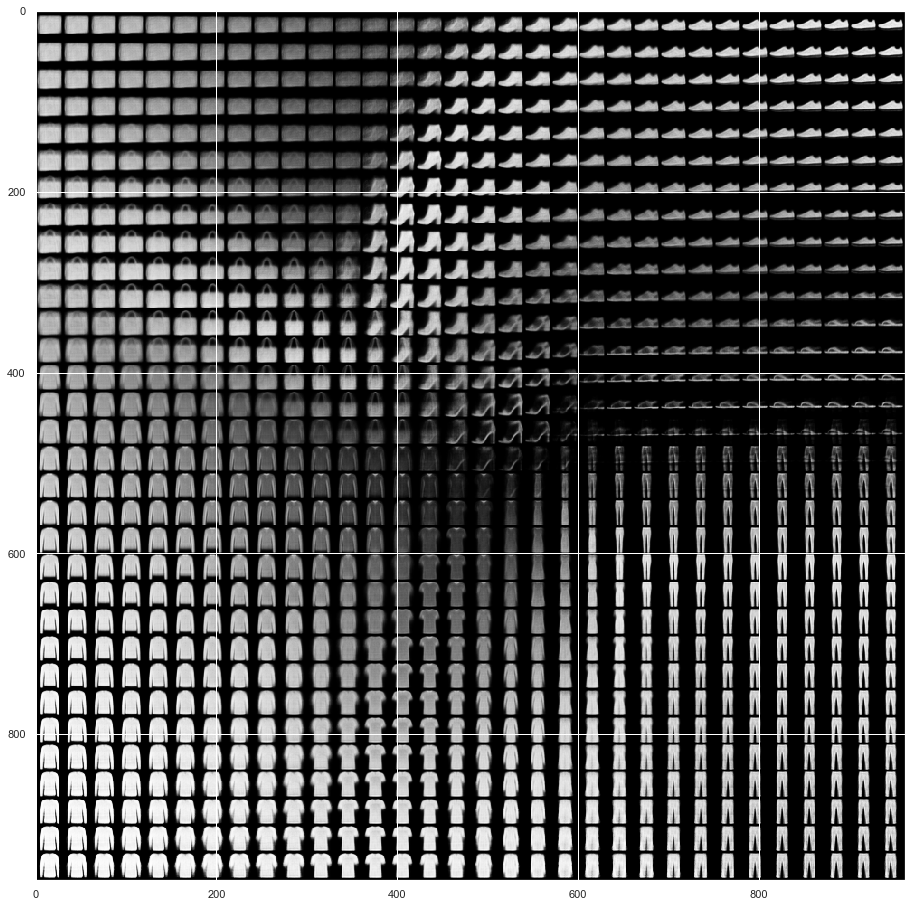

In [24]:
assert z_size == 2

lspace = torch.linspace(-1.5, 1.5, 32)
xs = lspace.view(1, 32, 1).repeat(32, 1, 1)
ys = lspace.view(32, 1, 1).repeat(1, 32, 1)
zs = torch.cat((xs, ys), dim=2).view(32 * 32, 2).to(device)
fantasies = model.generate(32 * 32, device, z=zs)
img1 = make_grid(fantasies.view(32 * 32, 1, 28, 28), nrow=32)
fig, ax = plt.subplots(figsize=(16, 16))
show(img1, ax);

## Interpolating in the latent space (it works for any z)

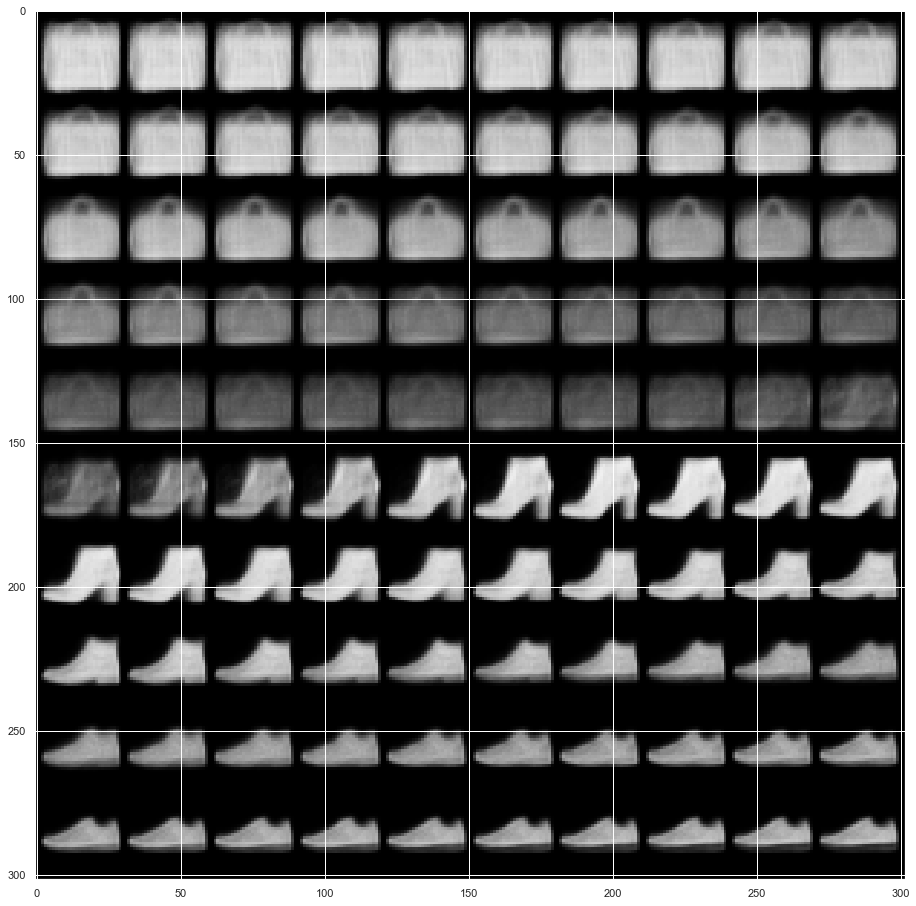

In [25]:
z1 = torch.randn((1, z_size))
z2 = torch.randn((1, z_size))

alpha = torch.linspace(0, 1, 100).view(100, 1).repeat(1, z_size)
zs = z1 * alpha + z2 * (1 - alpha)
fantasies = model.generate(10 * 10, device, z=zs.to(device))
img1 = make_grid(fantasies.view(10 * 10, 1, 28, 28), nrow=10)
fig, ax = plt.subplots(figsize=(16, 16))
show(img1, ax);

In [26]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

C:\Users\Popescu Andrei\AppData\Local\Temp\ipykernel_10648\560633985.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax, orientation='vertical')


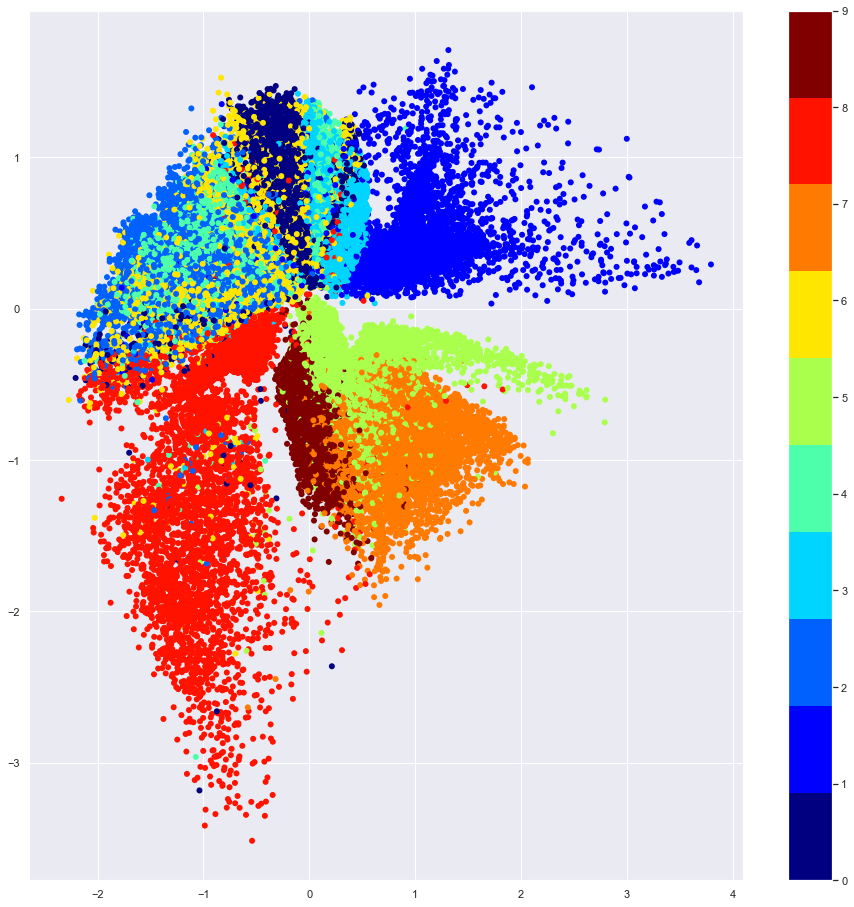

In [27]:
all_codes = torch.cat(list(torch.cat((model(data)[1].type(torch.FloatTensor), target.unsqueeze(1).type(torch.FloatTensor)), dim=1) for data, target in train_loader), dim=0)
np_codes = all_codes.detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(16, 16))
im = ax.scatter(x=np_codes[:, 0], y=np_codes[:, 1], c=np_codes[:, 2].astype(np.int32), marker='o', edgecolor='none', cmap=discrete_cmap(10, 'jet'))
fig.colorbar(im, ax=ax, orientation='vertical')